# Example: Neural Networks – Relaxing walk

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [2]:
using Flux
using Flux: Chain, Dense, relu, mse, train!, params, ADAM
using Random
using Gogeta
using Gurobi
using JuMP
using Plots
using Revise
using QuasiMonteCarlo
using Images, FileIO

In this example, we are going to introduce the function `optimize_by_walking!()` that can be used to optimize MILP formulation of the neural network faster than optimizing the formulation directly. To understand the method in detail, see Tong, J et al. (2024)

We are going to optimize this function:
$$f(x,y) = \exp(-((x^2+y-7)^2+(x+y^2-7)^2)/20)$$

In [3]:

f(x,y) = exp(-((x^2+y-7)^2+(x+y^2-7)^2)/20)
 

f (generic function with 1 method)

## Innitialize Neural Network

In [4]:
dimension = 2

begin
    Random.seed!(12345);

    NN_model = Chain(
        Dense(dimension => 128, relu),
        Dense(128=>16, relu),
        Dense(16 => 1),
    )
end

Chain(
  Dense(2 => 128, relu),                # 384 parameters
  Dense(128 => 16, relu),               # 2_064 parameters
  Dense(16 => 1),                       # 17 parameters
)                   # Total: 6 arrays, 2_465 parameters, 10.004 KiB.

## Generate artificial dataset

In [5]:
# this function will allow to generate random floar number in a range
g = (a, b) -> b + (a - b) * rand()

#1 (generic function with 1 method)

Let $x\in[-5,5]$ and $y\in[-5,5]$

In [6]:
init_U = [5, 5];
init_L = [-5, -5];

We will generate 20000 datapoints and use 50% for training

In [7]:
N = 20000
dataset = zeros(N, 3)
counter = 1

for i = 1:N
    x = [g(init_L[1],init_U[1]), g(init_L[2], init_U[2])]
    dataset[i, :] = push!(x, f(x...))
end

X = dataset[:, 1:2];
y = dataset[:, 3];

sample = randsubseq(1:size(dataset, 1), 0.5)
X_train = Array{Float32}(X[sample, :])';
y_train = Array{Float32}(y[sample, :])';

notsample = [i for i in 1:size(dataset,1) if isempty(searchsorted(sample, i))]
X_test= Array{Float32}(X[notsample, :])';
y_test = Array{Float32}(y[notsample, :])';

data_train = Flux.Data.DataLoader((X_train, y_train), batchsize=128);

## Train Neural Network

epoch #10, training loss: 0.012521611526608467, test loss: 0.01229900773614645
epoch #20, training loss: 0.010284501127898693, test loss: 0.010381653904914856
epoch #30, training loss: 0.008596746250987053, test loss: 0.008750243112444878
epoch #40, training loss: 0.007385258562862873, test loss: 0.007515956647694111
epoch #50, training loss: 0.006420689634978771, test loss: 0.006510470993816853
epoch #60, training loss: 0.005609632004052401, test loss: 0.005667225923389196
epoch #70, training loss: 0.00481155700981617, test loss: 0.004852574784308672
epoch #80, training loss: 0.0034423833712935448, test loss: 0.0034351081121712923
epoch #90, training loss: 0.0025947114918380976, test loss: 0.0026564449071884155
epoch #100, training loss: 0.0018323776312172413, test loss: 0.00183580641169101
epoch #110, training loss: 0.0017548592295497656, test loss: 0.0017723614582791924
epoch #120, training loss: 0.0013520338106900454, test loss: 0.0013818145962432027
epoch #130, training loss: 0.00

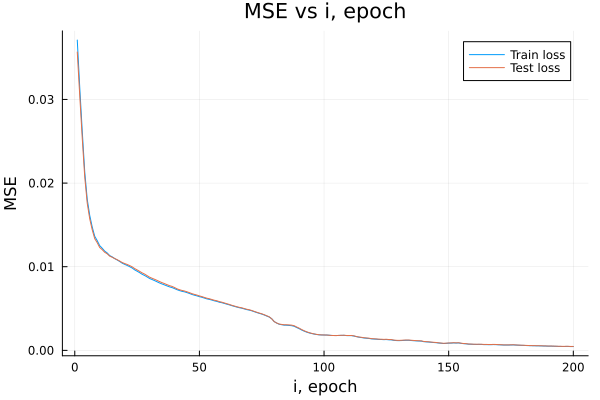

In [8]:
loss(x, y) = Flux.mse(NN_model(x), y)
opt = AdamW()
epochs = 200
train_losses = Float64[]
test_losses = Float64[]

for epoch in 1:epochs
    for (X_batch, y_batch) in data_train
        train!(loss, params(NN_model), [(X_batch, y_batch)], opt);
    end
    push!(train_losses, loss(X_train, y_train));
    push!(test_losses, loss(X_test, y_test))
    if epoch%10 == 0
        println("epoch #", epoch, ", training loss: ", train_losses[end], ", test loss: ", test_losses[end])
    end
end

plot(train_losses, xlabel="i, epoch", ylabel="MSE", title="MSE vs i, epoch", label="Train loss")
plot!(test_losses, label="Test loss")

## Formulate  NN as a MILP 

Formulate MILP model with fast bound tightening. Set objective funciton of the model as a maximization of the output neuron.

In [9]:
# Formulate the MIP with heuristic bound tightening
jump_model = Model(Gurobi.Optimizer)
set_silent(jump_model)
NN_formulate!(jump_model, NN_model, init_U, init_L; bound_tightening="fast");

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


In [10]:
x_range = LinRange{Float32}(init_L[1], init_U[1], 50);
y_range = LinRange{Float32}(init_L[2], init_U[2], 50);

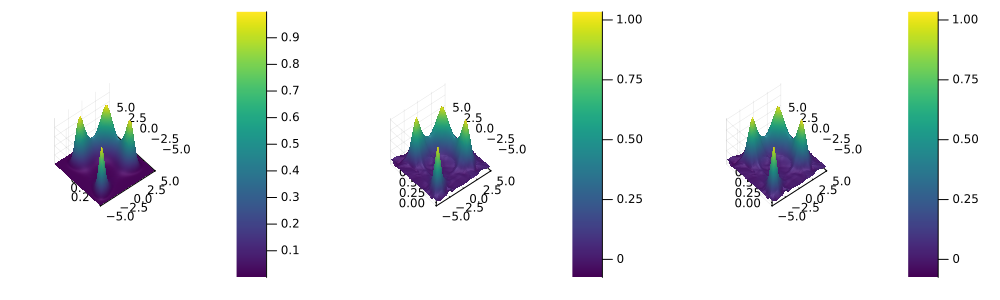

In [11]:
c_1 = plot(x_range, y_range, f, st=:surface, c=cgrad(:viridis), camera=(-40, 50))
c_2 = plot(x_range, y_range, (x, y) -> NN_model(hcat(x, y)')[], st=:surface, c=cgrad(:viridis), camera=(-40, 50))
c_3 = plot(x_range, y_range, (x, y) -> forward_pass!(jump_model, [x,y])[], st=:surface, c=cgrad(:viridis), camera=(-40, 50))
display(MIME"image/png"(), plot(c_1, c_2, c_3, layout=(1, 3), size=(1000, 300)))

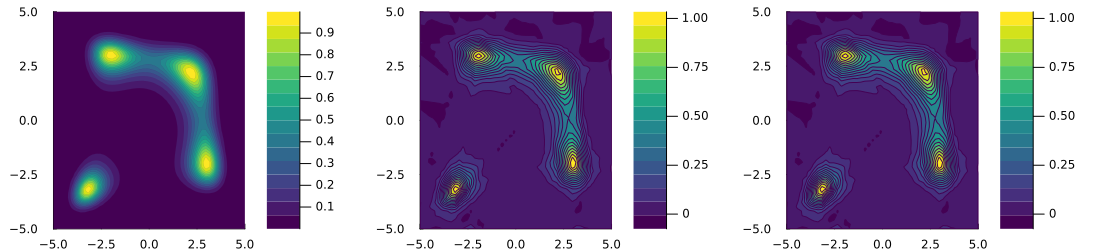

In [35]:
c_1 = plot(x_range, y_range, f, st=:contourf, c=cgrad(:viridis), lw=0)
c_2 = plot(x_range, y_range, (x, y) -> NN_model(hcat(x, y)')[], st=:contourf, c=cgrad(:viridis), camera=(-40, 50))
c_3 = plot(x_range, y_range, (x, y) -> forward_pass!(jump_model, [x,y])[], st=:contourf, c=cgrad(:viridis), camera=(-40, 50))
plot(c_1, c_2, c_3, layout=(1, 3), size=(1000, 250))

In [36]:
function set_solver!(jump)
    set_optimizer(jump, Gurobi.Optimizer)
    set_silent(jump)
end

set_solver! (generic function with 1 method)

In [41]:
last_layer, _ = maximum(keys(jump_model[:x].data));
@objective(jump_model, Max, jump_model[:x][last_layer, 1]);

@time x_opt, optimum = optimize_by_walking!(jump_model, NN_model, init_U, init_L);

println("\nFound approximately optimal solution:")
solution_1 = x_opt[argmax(optimum)];
opt_objective_1 = optimum[argmax(optimum)]
println("x = ", solution_1)
println("Objective value = ", opt_objective_1)
println("True value of function = ", f(solution_1...))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20
  1.995016 seconds (5.64 M allocations: 202.583 MiB, 1.50% gc time, 10.86% compilation time)

Found approximately optimal solution:
x = [3.014981559576537, -2.00930120052639]
Objective value = 1.067467794154884
True value of function = 0.9995369507237925


In [42]:
NN_formulate!(jump_model, NN_model, init_U, init_L; bound_tightening="fast");
@objective(jump_model, Max, jump_model[:x][last_layer, 1]);

@time optimize!(jump_model)

println("\nFound approximately optimal solution:")
solution_2 = [i for i in value.(jump_model[:x][0, :])];
opt_objective_2 = objective_value(jump_model)

println("x = ", solution_2)
println("Objective value = ",  opt_objective_2)
println("True value of function = ", f(solution_2...))

  3.633606 seconds (30.88 k allocations: 1.408 MiB, 0.05% compilation time)

Found approximately optimal solution:
x = [3.015110159375812, -2.0085645242244587]
Objective value = 1.067486629265034
True value of function = 0.9995390144451871


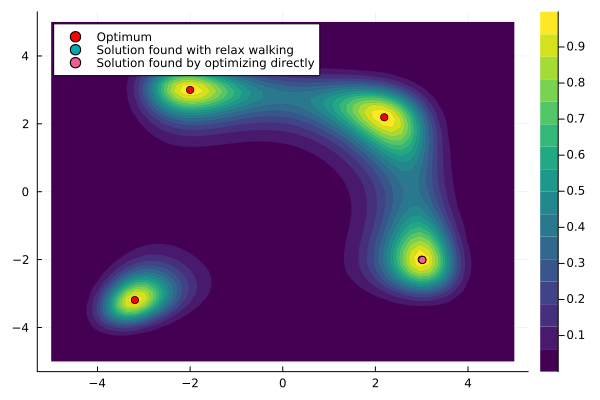

In [44]:
plot(x_range, y_range, f, st=:contourf, c=cgrad(:viridis), lw=0)
scatter!([-2], [3], label="Optimum", color="red")
scatter!([3], [-2], color="red", label=false)
scatter!([-3.19258], [-3.19258], color="red", label=false)
scatter!([2.19258], [2.19258], color="red", label=false)
scatter!([solution_1[1]], [solution_1[2]], label="Solution found with relax walking")
scatter!([solution_2[1]], [solution_2[2]], label="Solution found by optimizing directly")

As we can see the optimum solution found by relax walking algorithm is close enough to one of the global maximums of the function:

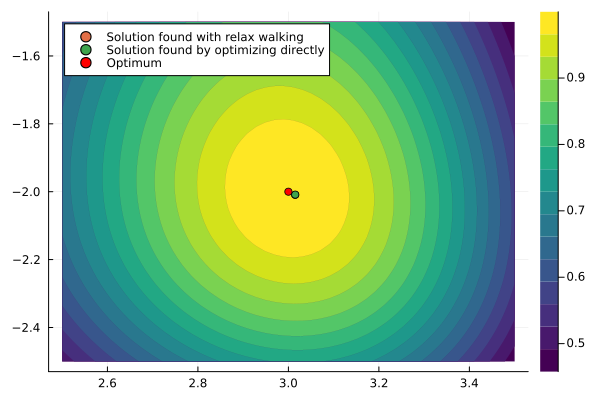

In [51]:

x_range = LinRange{Float32}(2.5, 3.5, 50);
y_range = LinRange{Float32}(-2.5, -1.5, 50);
plot(x_range, y_range, f, st=:contourf, c=cgrad(:viridis), lw=0)
scatter!([solution_1[1]], [solution_1[2]], label="Solution found with relax walking")
scatter!([solution_2[1]], [solution_2[2]], label="Solution found by optimizing directly")
scatter!([3], [-2], color="red", label="Optimum")

In [45]:
relax_integrality(jump_model)
plot(x_range, y_range, (x, y) -> forward_pass!(jump_model, [x,y])[], st=:contourf, c=cgrad(:viridis))

i = 1

if isdir("frames")
    rm("frames", recursive=true)
end 

mkdir("frames")

for x in range(-2.9, 2.9, 10), y in range(-2.9, 2.9, 15)
    _, _, path = local_search([x, y], jump_model, init_U, init_L; show_path=true)
    heights = [NN_model(path[i])[] for i in eachindex(path)]
    plotd = plot!(first.(path), last.(path), heights .+ 0.1, marker=:circle, legend=false, lw=3)
    savefig(plotd,"frames/frame_$i.png")
    i+=1
end

# Load images
image_files = ["frames/frame_$j.png" for j in 1:i-1]
images = [load(file) for file in image_files]
rm("frames", recursive=true)
# Create and save the GIF
save("animation.gif", cat(images..., dims=3))


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 128, relu)  # 384 parameters
│   summary(x) = "2-element Vector{Float64}"
└ @ Flux ~/.julia/packages/Flux/Wz6D4/src/layers/stateless.jl:60


![alt text](animation.gif)

In [47]:
if isdir("frames")
    rm("frames", recursive=true)
end 

mkdir("frames")

plot(x_range, y_range, f, st=:contourf, c=cgrad(:viridis), lw=0)
i = 1
for x in x_opt
    if x==solution_1
        plotd = plot!([x[1]], [x[2]],  marker=:circle, legend=false, color="red")
    else
        plotd = plot!([x[1]], [x[2]] ,  marker=:circle, legend=false, color="blue")
    end

    savefig(plotd,"frames/frame_$i.png")
    i+=1
end

# Load images
image_files = ["frames/frame_$j.png" for j in 1:i-1]
images = [load(file) for file in image_files]
rm("frames", recursive=true)
# Create and save the GIF
save("animation_2.gif", cat(images..., dims=3))


![alt text](animation_2.gif)